# Debug Bert notebook
- [x] trivial case, with predicting shifted tokens, instead of mlm.
- [x] trivial case, of classifying presence of marker token, at a random position.

In [1]:
%load_ext autoreload
%autoreload 2

import tokentango

TokenTango


In [2]:
import torch
from torch.optim import Adam, AdamW
from torch import nn, functional as F
from plotly import express as px

In [3]:
device = torch.device("mps")

In [4]:
# 1. Embeddings padding_idx = 0, might conflict with cls, or other tokens? (model.py)
# 2. xs, masks and cls classes are all made with seperate calls to train_test_split (in bert_from_scratch.py)
#    so maybe the cls' dont match the text
num_samples = 2000

xs = torch.randint(low=1, high=10, size=(num_samples,5), dtype=torch.int32)
xs = torch.cat([torch.zeros(num_samples, 1, dtype=torch.int), xs], dim=1).to(device)

ys = xs.clone()
cls_label = [float(any(n == 1 for n in xs[i,:])) for i in range(num_samples)]

split_at = int(0.2 * num_samples)

train_x = xs[:split_at, :]
train_y = ys[:split_at, :]
train_cls = cls_label[:split_at]

test_x = xs[split_at:, :]
test_y = ys[split_at:, :]
test_cls = cls_label[split_at:]

In [5]:
model = tokentango.BertClassifier(6, 10, device).to(device)
model.train()

# 3. Maybe change named_parameters to parameters? (also in bert_from_scratch.py)
optimizer = AdamW(model.parameters(), lr = 1e-4, eps = 1e-8)
#optimizer = Adam(model.parameters(), lr = 1e-4)

In [6]:
num_epochs = 3
mlm_losses = []
cls_losses = []
batch_size = 32

for epoch in range(0, num_epochs):
    for idx in range(0, int(num_samples/batch_size), batch_size):
        optimizer.zero_grad()

        x = train_x[idx:idx+batch_size,:]
        y = train_y[idx:idx+batch_size,:]
        cls_class = torch.tensor(train_cls[idx:idx+batch_size]).to(device)

        hidden = model.hidden(x)
        loss_cls = model.classify_loss(hidden, cls_class)
        loss_mlm = model.mlm_loss(hidden, y)
        loss = loss_cls + loss_mlm
        loss.backward()
        optimizer.step()
        
        mlm_losses.append(loss_mlm.cpu().item())
        cls_losses.append(loss_cls.cpu().item())

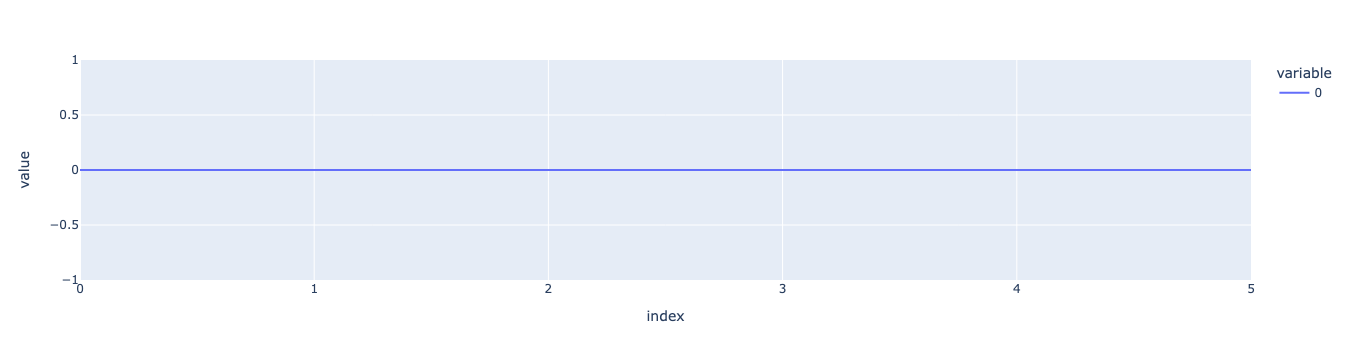

In [7]:
px.line(mlm_losses)

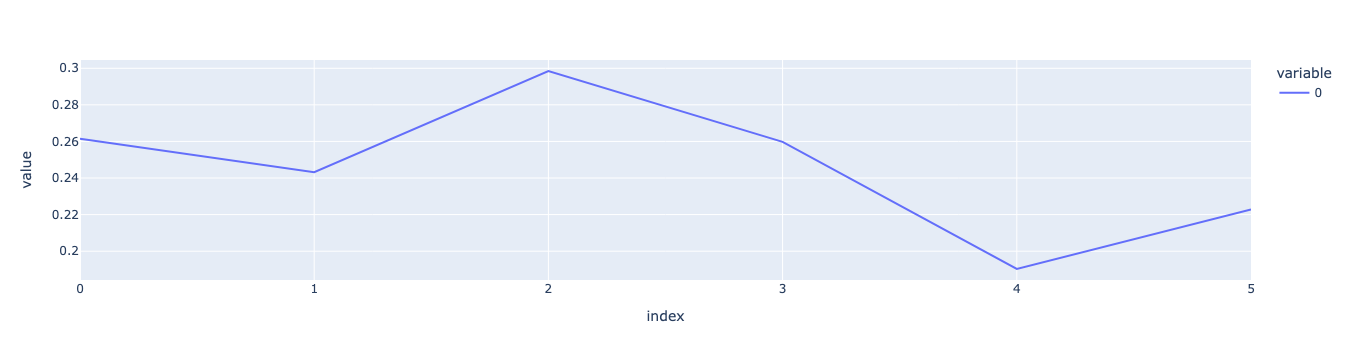

In [8]:
px.line(cls_losses)

In [10]:
outputs = []
num_samples = len(test_cls)

model.eval()
with torch.no_grad():
    for idx in range(0, num_samples):
        x = train_x[idx:idx+1,:]
        hidden = model.hidden(x)
        output = model.classifier(model.preclassifier(hidden[:,0]).relu())
        outputs.append(output)

outputs = torch.cat(outputs)

predicted_values = torch.round(outputs)
predicted_values = predicted_values.cpu().view(-1).numpy()
true_values = test_cls.cpu().numpy()
label_values = ["A", "B"]

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

RuntimeError: [srcBuf length] > 0 INTERNAL ASSERT FAILED at "/Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/OperationUtils.mm":565, please report a bug to PyTorch. Placeholder tensor is empty!